# MRC Data Portal Webscapper
***Michael Brechbühler (eawag), 26.06.2023***

This python notebook uses the Selenium webdriver and Chrome to scrape time-series data from the **[Mekong River Comission Data Portal](https://portal.mrcmekong.org/time-series/dashboard)**. The portal allows to preview the entire time-series as a chart based on highcharts. This script will scrape data from the charts and create outputs as .csv time-series files and .html plots. **The user can select the desired parameter to extract in code-block 1B.**

## 0A: Imports

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import hvplot.pandas
import holoviews as hv
import seaborn as sns
from tqdm import tqdm
import random
import time
from pathlib import Path
import json
import urllib.request
import os
import numpy as np
from tqdm import tqdm

# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver import Chrome, ChromeOptions
# from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

# from selenium import webdriver
# from webdriver_manager.chrome import ChromeDriverManager

## 1A: Get station metadata
Collect all available datasets and plot a barplot for the different available parameters.

In [21]:
# Download time-series data metadata from MRC API
url = r'https://api.mrcmekong.org/api/v1/ts/inventory/timeSeriesList'
urllib.request.urlretrieve(url, 'timeSeriesList.json')
print(f'Downloaded time-series metadata from {url} .')

# Opening JSON file
f = open('timeSeriesList.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
df_metadata = pd.DataFrame([])
for dataset in data:
    df_temp = pd.DataFrame([dict(dataset)])
    df_temp['longitude'] = df_temp['longitude'].astype(float)
    df_temp['latitude'] = df_temp['latitude'].astype(float)
    df_metadata = pd.concat([df_temp, df_metadata])

# Closing file
f.close()
print(f'Found a total of {df_metadata.shape[0]} time-series datasets from {len(df_metadata.stationCode.unique())} stations of the MRC Data Portal.')

# Get Barplot of data
plot_bar = df_metadata.groupby('parameter').count().uniqueId.hvplot.bar(
    rot=90, title='MRC Data Portal datasets by parameter', xlabel='')

plot_bar

Downloaded time-series metadata from https://api.mrcmekong.org/api/v1/ts/inventory/timeSeriesList .
Found a total of 4116 time-series datasets from 921 stations of the MRC Data Portal.


:Bars   [parameter]   (uniqueId)

Create plots of all available datasets for parameters of interest.

In [22]:
params_of_interest = [#'Turbidity, FTU', 
                      #'Turbidity, Form Neph',
                      'Total Suspended Solids', 
                      'Sediment Flux',
                      'Sediment Concentration', 
                      'Discharge']

end_time_lim = pd.to_datetime('2013-02-11')

df_metadata_subset = df_metadata.loc[(df_metadata.parameter.isin(params_of_interest)) &
                                       ([x.date()>end_time_lim.date() for x in pd.to_datetime(df_metadata.correctedEndTime)])]

df_metadata_subset_DSMP = df_metadata_subset.loc[df_metadata_subset.label.str.contains('DSMP')]
df_metadata_subset_WQMP = df_metadata_subset.loc[~df_metadata_subset.label.str.contains('DSMP')]

C:\Users\Michael\AppData\Local\Temp\ipykernel_16884\279973159.py:10: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  df_metadata_subset = df_metadata.loc[(df_metadata.parameter.isin(params_of_interest)) &


In [ ]:
# Get Barplot of data

plots = []
ylim = (0,60)

df_data_WQMP = df_metadata_subset_WQMP.groupby('parameter').count()
plot_bar = df_data_WQMP.hvplot.bar(
    x='parameter', y='uniqueId',
    rot=0, title='MRC WQMP datasets', 
    width=400, height=400, ylim=ylim,
    xlabel='', ylabel='Number of datasets')
labels = hv.Labels(data=df_data_WQMP.reset_index()).opts(yoffset=2)

plots.append(plot_bar * labels)

df_data_DSMP = df_metadata_subset_DSMP.groupby('parameter').count()
plot_bar = df_data_DSMP.hvplot.bar(
    x='parameter', y='uniqueId',
    rot=0, title='MRC DSMP datasets', 
    width=400, height=400, ylim=ylim,
    xlabel='', ylabel='Number of datasets')
labels = hv.Labels(data=df_data_DSMP.reset_index()).opts(yoffset=2)

plots.append(plot_bar * labels)

hv.Layout(plots).cols(1).opts(shared_axes=False)

In [ ]:
# read polygons
gdf_basin = gpd.read_file(r'polygons\shp\basin_polygons.shp')
gdf_basin = gdf_basin.loc[gdf_basin.name=='Mekong'][['geometry']]
gdf_3s = gpd.read_file(r'polygons\shp\3s_basin.shp')[['geometry']]

# create gdf
gdf_metadata_subset = gpd.GeoDataFrame(df_metadata_subset,
                       crs={'init': 'epsg:4326'},
                       geometry=df_metadata_subset.apply(lambda row: shapely.geometry.Point((row.longitude, row.latitude)), axis=1)).reset_index()

# correct coordinates for 3S datasets
dict_coords = {
    '430102': {'latitude': 14.11961739545873, 
               'longitude': 106.39220569493087,
               'source': 'https://www.mrcmekong.org/assets/Publications/LMWQ-Report-2019.pdf'
              }, # Siempang
    '451305': {'latitude': 12.897991717109619, 
               'longitude': 107.78237137912318, 
               'source': 'MRC-Q4_velocity-Index-measurements.xls'
              }, # Ban Don
    '450101': {'latitude': 13.500873237656885, 
               'longitude': 106.96999779076059, 
               'source': 'https://portal.mrcmekong.org/time-series'
              }, # Lum Phat
    '440202': {'latitude': 13.940093424442852,
               'longitude': 107.47041987706022,
               'source': 'https://www.mrcmekong.org/assets/Publications/Council-Study/005-Council-Study-BioRA-Progress-Report-1-Indicators-and-Focus-Sites-Revised.pdf'
              }, # Pleiku
    '440103': {'latitude': 14.050489408398247,
               'longitude': 107.10639453530615, 
               'source': 'https://www.mrcmekong.org/assets/Publications/LMWQ-Report-2019.pdf'
              }, # Andaung Meas
    '440100': {'latitude': 13.792268298200513, 
               'longitude': 107.44760623609672,
               'source': 'https://www.mrcmekong.org/assets/Publications/LMWQ-Report-2019.pdf'
              }, # Phum Pi
    '014501': {'latitude': 13.537303972542501,
               'longitude': 105.987503299606, 
               'source': 'Mekong_HYCOS_Project-Document-FifthDraft-July06.doc'
              }, # Stung Treng
}

for key, value in dict_coords.items():
    idx = gdf_metadata_subset.loc[gdf_metadata_subset.stationCode==key].iloc[0].name
    lat, lon = value['latitude'], value['longitude']
    gdf_metadata_subset.loc[idx, 'latitude'] = lat
    gdf_metadata_subset.loc[idx, 'longitude'] = lon
    gdf_metadata_subset.loc[idx, 'geometry'] = shapely.Point(lon, lat)
    
# create subsets for WQMP and DSMP
gdf_metadata_subset_DSMP = gdf_metadata_subset.loc[(gdf_metadata_subset.label.str.contains('DSMP')) &
                                                  (gdf_metadata_subset.parameter=='Sediment Concentration')]
gdf_metadata_subset_WQMP = gdf_metadata_subset.loc[(~gdf_metadata_subset.label.str.contains('DSMP')) &
                                                  (gdf_metadata_subset.parameter=='Total Suspended Solids')]


In [ ]:
# get Mapplot of data
plots = []

mapplot_wqmp = gdf_metadata_subset_WQMP.hvplot.points(
        x='longitude', y='latitude', geo=True, tiles='CartoLight',
        features={'rivers':'10m', 'lakes':'10m', 'borders': '10m', 'coastline':'10m'},
        title='MRC WQMP datasets',
        label='Sediment station', legend='top_right', size=40,
        xlabel='Longitude', ylabel='Latitude',
        height=600, width=400, line_color='black') *\
    gdf_3s.hvplot.polygons(geo=True, 
                           hover_cols=['index'], colorbar=False,
                           label='3S Basin',
                           fill_color=None, fill_alpha=0, line_color='red')
plots.append(mapplot_wqmp)

mapplot_dsmp = gdf_metadata_subset_DSMP.hvplot.points(
        x='longitude', y='latitude', geo=True, tiles='CartoLight',
        features={'rivers':'10m', 'lakes':'10m', 'borders': '10m', 'coastline':'10m'},
        title='MRC DSMP datasets',
        label='Sediment station', legend='top_right', size=40,
        xlabel='Longitude', ylabel='Latitude',
        height=600, width=400, line_color='black') *\
    gdf_3s.hvplot.polygons(geo=True, 
                           hover_cols=['index'], colorbar=False,
                           label='3S Basin',
                           fill_color=None, fill_alpha=0, line_color='red')
plots.append(mapplot_dsmp)

hv.Layout(plots).cols(2)

In [ ]:
gdf_metadata_subset_WQMP_3S = gdf_metadata_subset_WQMP.loc[(gdf_metadata_subset_WQMP.intersects(gdf_3s.iloc[0].geometry)) | 
                                                        (gdf_metadata_subset_WQMP.stationName=='Stung Treng')]

gdf_metadata_subset_WQMP_3S.hvplot.points(
    x='longitude', y='latitude', geo=True, tiles='CartoLight',
    features={'rivers':'10m', 'lakes':'10m', 'borders': '10m', 'coastline':'10m'},
    title='MRC Data Portal - Datasets',
    label='TSS Station', legend=False, size=40,
    xlabel='Longitude', ylabel='Latitude',
    height=400, width=400, line_color='black') *\
gdf_3s.hvplot.polygons(geo=True, 
                       hover_cols=['index'], colorbar=False,
                       label='3S-basin',
                       legend=False,
                       fill_color=None, fill_alpha=0, line_color='red')

In [ ]:
gdf_metadata_subset_WQMP_3S[['locationIdentifier', 'stationName', 'startTime', 'endTime', 'river']]

## 1B: Select parameter to download
In this code-block the user can select the wanted parameter used to extract time-series data.

In [ ]:
# Select the desired parameter
parameter = 'Total Suspended Solids'

In [ ]:
# Collect metadata for all available datasets with the specified parameter
timeseries_ids = df_metadata.loc[df_metadata.parameter == parameter].uniqueId.unique()
df_datasets = pd.DataFrame([])
for unique_id in timeseries_ids:
    df_temp = df_metadata.loc[df_metadata.uniqueId == unique_id]
    df_datasets = pd.concat([df_datasets, df_temp])

print(f'Found {len(timeseries_ids)} time-series datasets with the parameter "{parameter}".')

df_datasets.to_csv(f'outputs/csv/{parameter.replace(" ","")}_locations.csv')
print(f'CSV-File with measuring station locations saved to "outputs/csv/".')

# Get mapplot of stations
df_map = df_datasets.copy()
df_map.latitude = df_map.latitude.astype(float)
df_map.longitude = df_map.longitude.astype(float)
plot_map = df_map.hvplot.points(
    geo=True, tiles='OSM',
    height=500,
    features={'rivers':'10m', 'borders':'10m'},
    color='red', line_color='black', marker='star', size=200,
    y='latitude', x='longitude',
    title=f'{parameter}\nMeasuring station locations ({len(timeseries_ids)})',
    ylabel='Latitude', xlabel='Longitude', label=f'Station', legend='bottom_right'
)

plot_map

## 2A: Run scrapping process
This code-block will start the scrapping process. A chrome window will open which iteratively loads the time-series data. In between datasets a wait time of 20-30 seconds is applied to ensure the data is loaded and not to many requests in a short amount of time are made. The exported .csv files and plots are located in the *outputs/* folder.

In [ ]:
def download_timeseries(metadata):
    # Get metadata
    unique_id = metadata['uniqueId']
    start = metadata['correctedStartTime'][0:10]
    end = metadata['correctedEndTime'][0:10]
    parameter = metadata['parameter']
    station_code = str(metadata['stationCode'])
    station_name = str(metadata['stationName'])
    river = str(metadata['river'])
    latitude, longitude = str(metadata['latitude']), str(metadata['longitude'])
    interval = str(metadata['interval'])
    unit = str(metadata['unit'])
    country, country_code = str(metadata['country']), str(metadata['countryCode'])
    identifier = str(metadata['identifier'])
    utc_offset = str(metadata['utcOffset'])
    filename = identifier.replace(" ", "").replace('/', '')
    
    # skip if output already exists
    if os.path.exists(f'outputs/csv/{parameter}/{filename}.csv'):
        return()
    
    # Set url
    url = fr'https://portal.mrcmekong.org/time-series/chart?ts={unique_id}&sd={start}&ed={end}'
    
    # Call url through selenium driver
    driver.get(url)
    time.sleep(random.randint(20, 30))
    # Wait until element with highcharts graph appears
    WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.CLASS_NAME, "highcharts-container "))
    )

    # Scrape data to dataframe
    df_data = pd.DataFrame([])
    i = 0
    dates = driver.execute_script(f'return $("highcharts-chart").highcharts().series[{i}].xData.map(x => new Date(x).toISOString())')
    values = driver.execute_script(f'return $("highcharts-chart").highcharts().series[{i}].yData')
    # Parse data to dataframe
    df_series = pd.DataFrame({'identifier': identifier, 
                              'station_code': station_code, 
                              'station_name': station_name, 
                              'parameter': parameter,
                              'date': dates, 
                              'value': values,
                              'river': river,
                              'lat': latitude, 'lon': longitude,
                              'unit': unit,
                              'country_code': country_code, 'country': country,
                              'interval': interval,
                              'utc_offset': utc_offset
                             })
    df_series['date'] = pd.to_datetime(df_series['date'])
    start, end = df_series['date'].sort_values().iloc[0], df_series['date'].sort_values().iloc[-1]

    # Export csv
    if not(os.path.exists(f'outputs/csv/{parameter}/')):
        os.mkdir(f'outputs/csv/{parameter}/')
    df_series.to_csv(f'outputs/csv/{parameter}/{filename}.csv', index=False)
    print(f'Exported data from dataset {identifier} from {start} to {end}.')
    
    # Generate plot and save as html
    width, height = 1200, 400
    # Time-series
    plot_timeseries = df_series.hvplot.line(x='date', y='value', 
           title=f'{station_name} ({station_code}) - {parameter}',
           width=width, height=height,
           xlabel='Date', ylabel=f'{parameter} ({unit})')*\
    df_series.hvplot.scatter(x='date', y='value', 
                       color='orange', line_color='black')
    # Mapplot (only if coordinates are in metadata)
    width, height = 600, 600
    df_map = df_series.copy().head(1)
    if df_map.lat.iloc[0] != 'None':
        df_map.lat = df_map.lat.astype(float)
        df_map.lon = df_map.lon.astype(float)
        lat, lon = df_map.iloc[0].lat, df_map.iloc[0].lon
        buffer = 0.01
        plot_map = df_map.hvplot.points(
            geo=True, tiles='OSM',
            width=width, height=height,
            xlim=(lon-buffer, lon+buffer), ylim=(lat-buffer, lat+buffer),
            #features={'rivers':'10m', 'borders':'10m'},
            color='red', line_color='black', marker='star', size=200,
            y='lat', x='lon',
            title=f'{station_name} ({station_code}) - Location',
            ylabel='Latitude', xlabel='Longitude', label='Station', legend='bottom_right'
        )
        # Combine plots
        plots = hv.Layout([plot_timeseries, plot_map]).cols(1)
    else:
        plots = plot_timeseries
    if not(os.path.exists(f'outputs/plots/{parameter}/')):
        os.mkdir(f'outputs/plots/{parameter}/')
    hv.save(plots, 
            f'outputs/plots/{parameter}/{filename}.html', 
            fmt='html')

    # Merge series for further use
    df_data = pd.concat([df_data, df_series])

## Start scrapping process
# Initialize driver
driver = webdriver.Chrome()

# Extract timeseries for all ids
for idx, row in tqdm(df_datasets.iterrows()):
    download_timeseries(row)

# Quit the driver
driver.quit()

## 3B: Plot data
This code-block will create an interactive plot that can display all downloaded datasets. The plot will be saved to *outputs/plots/$parameter/*.

In [202]:
df_data_dsmp = df_data.loc[df_data.identifier.str.contains('DSMP')]
df_dsmp_stations = df_data_dsmp.station_code.unique()
df_dsmp_stations

array(['014501', '014901', '019801', '020102', 'KNR', 'OSP', 'SKB',
       '013901', '010501', '011903', '012001', '013101', '013402',
       '013801', '019803', '039801'], dtype=object)

In [216]:
df_dsmp_stations

,identifier,station_name,parameter,date,value,river,lat,lon,unit,country_code,country,interval,utc_offset,med_frq
station_code,,,,,,,,,,,,,,
010501,Sediment Concentration.Measured DSMP@TH_010501...,Chiang Saen,Sediment Concentration,2009-01-05 17:00:00+00:00,145.840000,Mekong,20.274120,100.088547,mg/l,TH,Thailand,Unknown,7,7 days 00:00:00
011903,Sediment Concentration.Measured DSMP@TH_011903...,Chiang Khan,Sediment Concentration,2009-01-06 17:00:00+00:00,42.130000,Mekong,17.900261,101.669891,mg/l,TH,Thailand,Unknown,7,7 days 00:00:00
012001,Sediment Concentration.Measured DSMP@TH_012001...,Nong Khai,Sediment Concentration,2009-01-08 17:00:00+00:00,55.970000,Mekong,17.881439,102.732201,mg/l,TH,Thailand,Unknown,7,7 days 00:00:00
013101,Sediment Concentration.Measured DSMP@TH_013101...,Nakhon Phanom,Sediment Concentration,2012-01-08 17:00:00+00:00,30.613109,Mekong,17.425369,104.773933,mg/l,TH,Thailand,Unknown,7,13 days 00:00:00
013402,Sediment Concentration.Measured DSMP@TH_013402...,Mukdahan,Sediment Concentration,2009-01-05 17:00:00+00:00,87.140000,Mekong,16.582800,104.733177,mg/l,TH,Thailand,Unknown,7,7 days 00:00:00
013801,Sediment Concentration.Measured DSMP@TH_013801...,Khong Chiam,Sediment Concentration,2009-01-07 17:00:00+00:00,101.510000,Mekong,15.322090,105.493477,mg/l,TH,Thailand,Unknown,7,7 days 00:00:00
013901,Sediment Concentration.Measured DSMP@LA_013901...,Pakse,Sediment Concentration,2011-06-16 17:00:00+00:00,98.800000,Mekong,15.099760,105.813187,mg/l,LA,Lao PDR,Unknown,7,8 days 00:00:00
014501,Sediment Concentration.Measured DSMP@KH_014501...,Stung Treng,Sediment Concentration,2011-06-07 17:00:00+00:00,52.060000,Mekong,13.532500,105.950188,mg/l,KH,Cambodia,Unknown,7,10 days 00:00:00
014901,Sediment Concentration.Measured DSMP@KH_014901...,Kratie,Sediment Concentration,2011-06-06 17:00:00+00:00,62.000000,Mekong,12.481410,106.017616,mg/l,KH,Cambodia,Unknown,7,9 days 00:00:00


In [225]:
# Load data from DSMP surves
paths_data_q = list(Path(f'outputs/csv/Sediment Concentration/').glob(f'*.csv'))
paths_data_s = list(Path(f'outputs/csv/Discharge/').glob(f'*.csv'))
paths_data = paths_data_q + paths_data_s
df_data = pd.DataFrame([])
for path in paths_data:
    df_temp = pd.read_csv(path, dtype={'station_code':'str'})
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp['med_frq'] = np.median(np.diff(df_temp.date))
    df_data = pd.concat([df_data, df_temp])


df_data_dsmp = df_data.loc[df_data.identifier.str.contains('DSMP')]
df_dsmp_stations = df_data_dsmp.groupby('station_code').first()
df_data_dsmp = df_data.loc[df_data.station_code.isin(df_dsmp_stations.index)]
    
# Create geodataframe
gdf_stations = gpd.GeoDataFrame(df_dsmp_stations,
                 crs={'init': 'epsg:4326'},
                 geometry=df_dsmp_stations.apply(lambda row: shapely.geometry.Point((row.lon, row.lat)), axis=1)
                )

C:\ProgramData\Anaconda3\envs\sos_water\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [226]:
gdf_labels = gdf_metadata_dsmp.groupby('stationName').first().reset_index().set_crs("EPSG:4326").to_crs("EPSG:3857")
gdf_labels['latitude_3857'] = gdf_labels.geometry.apply(lambda x: x.coords[0][1])
gdf_labels['longitude_3857'] = gdf_labels.geometry.apply(lambda x: x.coords[0][0])
labels = gdf_labels.hvplot.labels(x='longitude_3857', y='latitude_3857', text="stationName", text_color='black')

gdf_metadata_dsmp.hvplot.points(geo=True, tiles='OSM', color='parameter', hover_cols=['stationName', 'parameter']) *\
    labels

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (parameter,stationName)
   .Labels.I :Labels   [longitude_3857,latitude_3857]   (stationName)

R² = 0.4020635516712323
RMSE = 110.73315482660536
R² = 0.10934094902458669
RMSE = 248.6118879827632
R² = 0.5297849739949807
RMSE = 62.8736751457365
R² = 0.5596561257406052
RMSE = 43.21237615095345
R² = 0.7327967494330743
RMSE = 54.373250499675095
R² = 0.4250501972330696
RMSE = 153.04608928522688
R² = 0.37501587819150406
RMSE = 189.28505362403791
R² = 0.6385110285066271
RMSE = 77.93271253895925
R² = 0.6736290198354838
RMSE = 57.67755385007554
019801: No WQM discharge data
019801: Skipping..
020102: No WQM discharge data
020102: Skipping..
KNR: No WQM discharge data
KNR: Skipping..
OSP: No WQM discharge data
OSP: Skipping..
SKB: No WQM discharge data
SKB: Skipping..
019803: No WQM discharge data
019803: Skipping..
039801: No WQM discharge data
039801: Skipping..


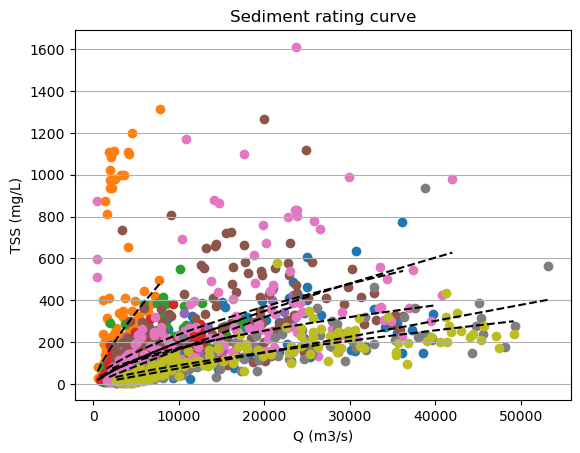

In [277]:
for station_code in df_data_dsmp.station_code.unique()[:]:
    df_q_dsmp = df_data.loc[(df_data.station_code==station_code) & (df_data.identifier.str.contains('DSMP'))].set_index('date')
    start, end = pd.to_datetime(df_q_dsmp.index.values[0]).date(), pd.to_datetime(df_q_dsmp.index.values[-1]).date()
    df_q_wqm = df_data.loc[(df_data.station_code==station_code) & ~(df_data.identifier.str.contains('DSMP'))].sort_values('date').set_index('date')[str(start):str(end)]
    df_sedi = df_data.loc[(df_data.station_code==station_code) & (df_data.parameter=='Sediment Concentration')].sort_values('date').set_index('date')[str(start):str(end)]
    
    if df_q_dsmp.shape[0] == 0:
        print(f'{station_code}: No DSMP discharge data')
    if df_q_wqm.shape[0] == 0:
        print(f'{station_code}: No WQM discharge data')
    if df_sedi.shape[0] == 0:
        print(f'{station_code}: No sediment data')
    if (df_q_wqm.shape[0] == 0) | (df_sedi.shape[0] == 0):
        print(f'{station_code}: Skipping..')
        continue
        
    for idx, row in df_sedi.iterrows():
        try:
            df_sedi.loc[idx, 'q'] = df_q_wqm.loc[str(row.name.date())]['value']
        except:
            continue

    # Create sediment rating curve for interpolation
    import scipy
    from sklearn import metrics
    import matplotlib.pyplot as plt
    
    def ratingCurve(x, a, b):
        return a * np.power(x, b)
    
    data = df_sedi.loc[(~df_sedi.value.isna()) & (~df_sedi.q.isna())].sort_values('q')
    
    # get data
    xs = data['q']
    ys = data['value']
    
    # perform the fit
    p0 = (15, 0.5) # start with values near those we expect
    params, cv = scipy.optimize.curve_fit(ratingCurve, xs, ys, p0, maxfev=100000)
    a, b = params
    
    # determine quality of the fit
    squaredDiffs = np.square(ys - ratingCurve(xs, a, b))
    squaredDiffsFromMean = np.square(ys - np.mean(ys))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    print(f"R² = {rSquared}")
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(ys, ratingCurve(xs, a, b)))}')
    
    # plot the results
    plt.grid(which='major', axis='y', zorder=-1.0)
    plt.scatter(xs, ys, label="data")
    plt.plot(xs, ratingCurve(xs, a, b), 'k--', label="fitted")
    plt.ylabel(r'TSS (mg/L)')
    plt.xlabel(r'Q (m3/s)')
    
    plt.title("Sediment rating curve")

In [ ]:
parameter = 'Sediment Concentration'

In [ ]:
# Load data from all stations
paths_data = list(Path(f'outputs/csv/{parameter}/').glob(f'*.csv'))
df_data = pd.DataFrame([])
for path in paths_data:
    df_temp = pd.read_csv(path, dtype={'station_code':'str'})
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp['med_frq'] = np.median(np.diff(df_temp.date))
    df_data = pd.concat([df_data, df_temp])
hv.output(widget_location='bottom', widget_type='individual')

# # Filter 3S datasets
# df_data_subset = df_data.loc[df_data.station_code.isin(gdf_metadata_valid.stationCode.values)]
# df_data = df_data_subset

In [ ]:
df_data_dsmp = df_data.loc[df_data.identifier.str.contains('Measured DSMP')]

for identifier in df_data.loc[df_data.identifier.str.contains('Measured DSMP')].identifier.unique():
    df_temp = df_data.loc[df_data.identifier==identifier].sort_values('date')
    start = df_temp.date.values[0]
    end = df_temp.date.values[-1]
    print(f'{identifier}: {start}, {end}')

In [ ]:
# Plot data
combined = True

if combined:
    plots = []
    for station in df_data.station_code.unique():
        df_data_temp = df_data.loc[df_data.station_code==station]
        plot_timeseries = df_data_temp.hvplot.line(x='date', y='value', 
               label=f'{station}',
               xlabel='Date', ylabel='TSM (mg/l)', width=800, height=250) *\
            df_data_temp.hvplot.scatter(x='date', y='value', marker='+', size=20)
        plots.append(plot_timeseries)
    plot = hv.Overlay(plots)
else:   
    plot_timeseries = df_data.hvplot.scatter(x='date', y='value', 
                   groupby='station_code', 
                   title='MRC time-series: Total Suspended Solids',
                   xlabel='', ylabel='TSM (mg/l)') *\
        df_data.hvplot.scatter(x='date', y='value', groupby='station_code',
                               color='orange', line_color='black')
    hv.save(plot_timeseries, f'outputs/plots/{parameter}_plots.html', fmt='html')
    plot = plot_timeseries
    
plot

## Export data for station subset used in Markert et al. (2018)

In [ ]:
# df_stations_markert

In [ ]:
# path_stations_markert = r"E:\git\SOS-Water\WP3\T3.2\GEE_TSM\tables\stations_markert2018.csv"
# df_stations_markert = pd.read_csv(path_stations_markert, delimiter=';')

# df_data_markert = pd.DataFrame()
# for idx, row in df_stations_markert.iterrows():
#     temp_id = row['Station ID'][1:]
#     temp_data = df_data.loc[df_data.station_code == temp_id]
#     if temp_data.shape[0] == 0: print(f'Station {temp_id} empty!')
#     temp_data['lat'], temp_data['lon'] = row['Lat.'], row['Lon.']
#     temp_data['system:time_start'] = temp_data['date'].apply(lambda x: str(x)[:10]+'T'+str(x)[11:19])
#     temp_data['waterbody'] = row['Waterbody']
#     temp_data['type'] = row['Type']
#     df_data_markert = pd.concat([temp_data, df_data_markert])
    
# df_data_markert.to_csv('outputs/csv/mrc_stations_markert.csv', sep=',', index=False)

In [ ]:
# df_data_markert.sort_values('date').iloc[-1]